**Install dependencies**

In [1]:
!pip install opencv-python mediapipe tensorflow tqdm scikit-learn

**Download dataset for training**

In [ ]:
# Download original dataset from GG Drive
!gdown 1ygIoqnlpg0kJDVRbtddG43Nece_jSPki -O original.zip
!unzip original.zip

# Download static dataset from GG Drive
# !gdown 1dZw-YTmRLSCglAeX5Y7NrTAYsjPydqtZ -O static.zip
# !unzip static.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw/Y_aug/Y_1617_aug_3.npy  
  inflating: raw/Y_aug/Y_1617_aug_4.npy  
  inflating: raw/Y_aug/Y_1618_aug_0.npy  
  inflating: raw/Y_aug/Y_1618_aug_1.npy  
  inflating: raw/Y_aug/Y_1618_aug_2.npy  
  inflating: raw/Y_aug/Y_1618_aug_3.npy  
  inflating: raw/Y_aug/Y_1618_aug_4.npy  
  inflating: raw/Y_aug/Y_1619_aug_0.npy  
  inflating: raw/Y_aug/Y_1619_aug_1.npy  
  inflating: raw/Y_aug/Y_1619_aug_3.npy  
  inflating: raw/Y_aug/Y_1619_aug_4.npy  
  inflating: raw/Y_aug/Y_1620_aug_0.npy  
  inflating: raw/Y_aug/Y_1620_aug_1.npy  
  inflating: raw/Y_aug/Y_1620_aug_2.npy  
  inflating: raw/Y_aug/Y_1620_aug_3.npy  
  inflating: raw/Y_aug/Y_1620_aug_4.npy  
  inflating: raw/Y_aug/Y_1621_aug_0.npy  
  inflating: raw/Y_aug/Y_1621_aug_1.npy  
  inflating: raw/Y_aug/Y_1621_aug_2.npy  
  inflating: raw/Y_aug/Y_1621_aug_3.npy  
  inflating: raw/Y_aug/Y_1621_aug_4.npy  
  inflating: raw/Y_aug/Y_1622_aug_2.npy  
  inflating: raw/Y_aug/Y_

**Import dependencies**

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

DATA_PATH = "/content/original" # Fix the approriate path

**Define key functions**

In [4]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results):
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

def extract_keypoints(image, results):
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        return np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]) if hand_landmarks.landmark else np.zeros((21,3))

**Prepare data by labeling**

In [ ]:
# This code for processing the new static dataset structure
alphabets = np.array(os.listdir(DATA_PATH))
label_map = {label: num for num, label in enumerate(alphabets)}

data, labels = [], []

for label in tqdm(alphabets):
    path = os.path.join(DATA_PATH, label, "npy")
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        try:
            keypoints = np.load(file_path)
            data.append(keypoints)
            labels.append(label_map[label])
        except Exception as e:
            print(f"Skipping file {file_path} due to error: {e}")

In [ ]:
# This code for processing original dataset structure
all_folders = os.listdir(DATA_PATH)
alphabets = sorted(set([f.split("_")[0] for f in all_folders]))

label_map = {label: num for num, label in enumerate(alphabets)}

data, labels = [], []

for folder in tqdm(all_folders):
    base_label = folder.split("_")[0]

    path = os.path.join(DATA_PATH, folder)
    # path = os.path.join(DATA_PATH, label, "npy")
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        try:
            keypoints = np.load(file_path)
            data.append(keypoints)
            labels.append(label_map[base_label])
        except Exception as e:
            print(f"Skipping file {file_path} due to error: {e}")

100%|██████████| 46/46 [00:20<00:00,  2.19it/s]


In [9]:
np.array(data).shape

(181097, 21, 3)

In [10]:
np.array(labels).shape

(181097,)

In [11]:
# Convert to arrays and one-hot encode labels
X = np.array(data)
y = to_categorical(labels).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [12]:
SAVE_DIR = "/content/result"
os.makedirs(SAVE_DIR, exist_ok=True)
np.save(f"{SAVE_DIR}/X_train", X_train)
np.save(f"{SAVE_DIR}/X_test.npy", X_test)
np.save(f"{SAVE_DIR}/y_train.npy", y_train)
np.save(f"{SAVE_DIR}/y_test.npy", y_test)
print("Save data in npy format successfully!")

Save data in npy format successfully!


**Train model**

In [13]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from keras.callbacks import TensorBoard
from keras.models import Sequential

log_dir = os.path.join("logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [15]:
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(21, 3)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(np.array(alphabets).shape[0], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=[tb_callback], verbose=1)

Epoch 1/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.4881 - loss: 1.6426
Epoch 2/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.8253 - loss: 0.5495
Epoch 3/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.8778 - loss: 0.3908
Epoch 4/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8991 - loss: 0.3146
Epoch 5/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.9149 - loss: 0.2661
Epoch 6/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9262 - loss: 0.2328
Epoch 7/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.9375 - loss: 0.2019
Epoch 8/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.9428 - loss: 0.1835
Epoch 9/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.9475 - loss: 0.1692
Epoch 10/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9511 - loss: 0.1569
Epoch 11/30
3962/3962 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.9537 - loss: 0.1488
Epoch 12/30
2045/39

KeyboardInterrupt: 

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 19, 64)         │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 7, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 23)             │         1,495 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 253,127 (988.78 KB)

 Trainable params: 84,375 (329.59 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 168,752 (659.19 KB)

In [19]:
# Test the predic capability of the model
res = model.predict(X_test)
print(alphabets[np.argmax(res[4])])
print(alphabets[np.argmax(y_test[4])])

1698/1698 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
V
V


In [20]:
# Save model
model.save("static_big.h5")

In [21]:
del model

**Evaluating the model**

In [22]:
# Load model for evaluation
from keras.models import load_model
model = load_model("static_big.h5")

In [23]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

1698/1698 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


In [24]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[54159,    13],
        [   45,   113]],

       [[50887,    42],
        [   74,  3327]],

       [[53825,     6],
        [   31,   468]],

       [[51622,    14],
        [  119,  2575]],

       [[51080,    50],
        [   27,  3173]],

       [[50377,    48],
        [   45,  3860]],

       [[51606,    14],
        [   18,  2692]],

       [[52089,   142],
        [  106,  1993]],

       [[53226,   109],
        [   40,   955]],

       [[52053,    77],
        [   52,  2148]],

       [[50758,    26],
        [   27,  3519]],

       [[53982,    22],
        [   82,   244]],

       [[53997,    63],
        [   28,   242]],

       [[51851,    34],
        [   38,  2407]],

       [[50921,    14],
        [   43,  3352]],

       [[52755,    14],
        [   23,  1538]],

       [[51491,    22],
        [   63,  2754]],

       [[51612,    42],
        [   20,  2656]],

       [[52013,   162],
        [   69,  2086]],

       [[51156,    34],
        [   45,  3095]],



In [25]:
accuracy_score(ytrue, yhat)

0.9796981409902448

In [26]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(ytrue, yhat)
print('Confusion matrix:')
print(cnf_matrix)

Confusion matrix:
[[ 113    0    0    0    0    4    0    6    4    1    2    0    0    0
     0    3    1    0    2    0    0    5   17]
 [   0 3327    0    0    0    3    0    3    0    0    0    1    0    0
     0    0    0    0   66    0    0    0    1]
 [   1    0  468    0    0    0    0    1    8    0    0    0    1    8
     0    0    0    2    0    0    0    4    6]
 [   1    0    0 2575   28    1    2   14   21    0    1    0    0    8
     1    1    1   10   18    1    0    7    4]
 [   0    0    0    9 3173    1    1    1    0    0    0    1    1    0
     2    0    0    0    1    0    0    9    1]
 [   0    9    1    0    4 3860    1    4    1    0    0    0    0    5
     0    0    0    0    7    0    0    7    6]
 [   4    0    2    0    0    1 2692    2    0    0    0    0    0    0
     3    0    0    0    4    1    0    0    1]
 [   0    6    2    1    0   16    1 1993   11   11    1    0    0    5
     2    2    3    4   33    1    5    1    1]
 [   0    0    0    1 

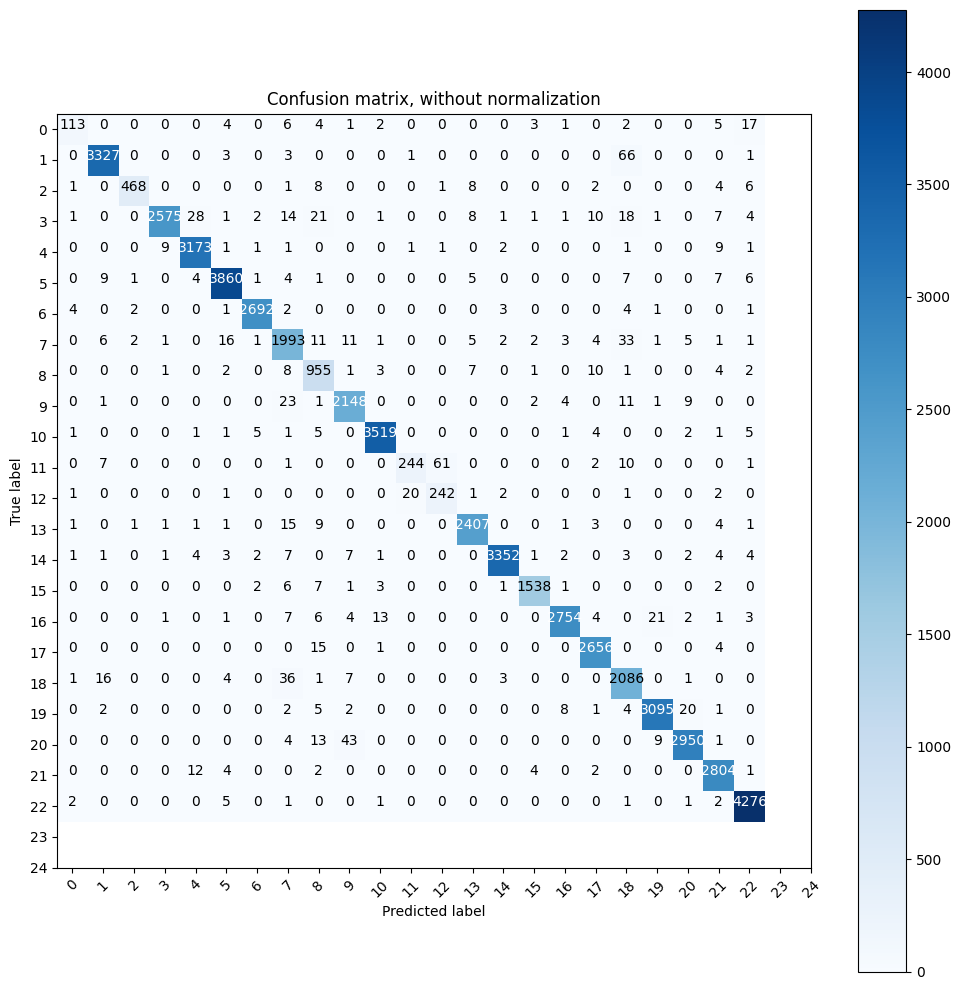

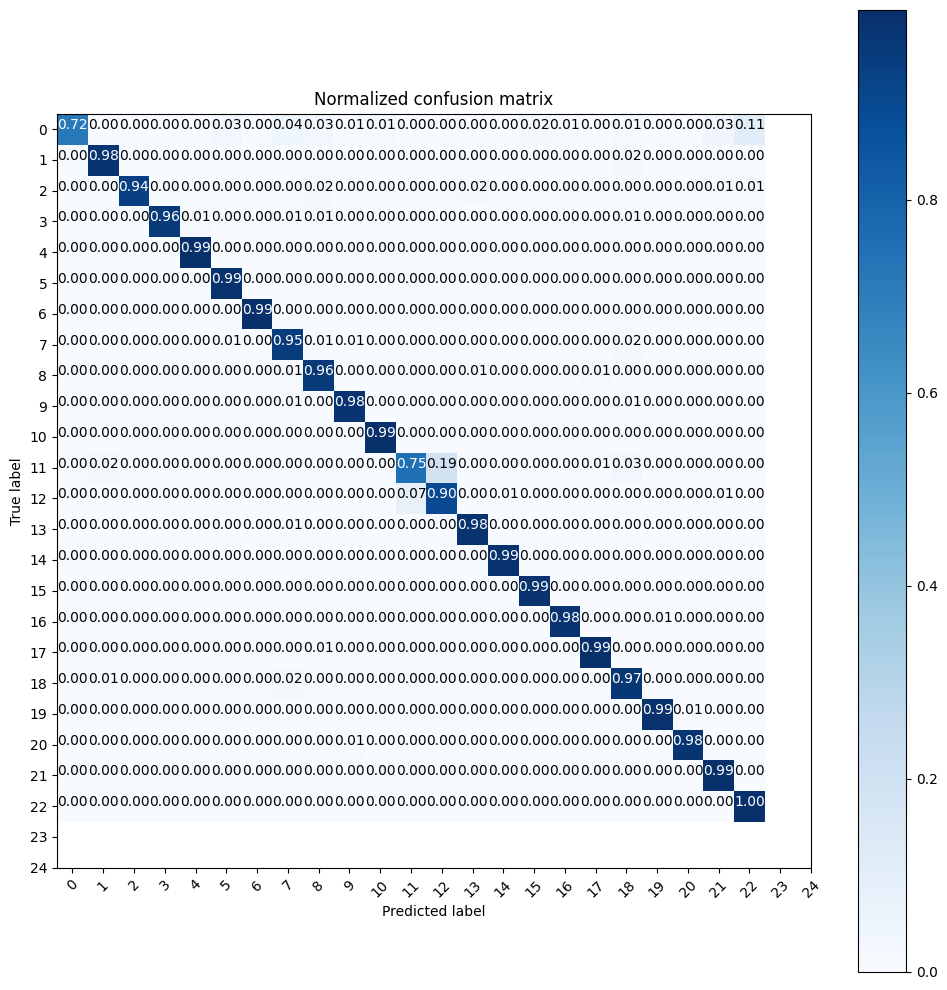

In [32]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
plt.figure(figsize = (10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize = (10, 10))
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()